In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gamma_formula(n_grados_libertad: int):
    return (n_grados_libertad + 2)/n_grados_libertad

def asignar_instantes(data: pd.DataFrame) -> list[float]:
    data["Instante"] = data["t"].rank(method='dense').astype(int)
    return data

def asignar_celdas(data: pd.DataFrame) -> list[float]:
    data["Celda"] = data["x"].rank(method='dense').astype(int)
    return data

def get_data_solucion(folder_resultado: str)-> pd.DataFrame:
    
    # Obtener datos de simulación c++
    # Obtener nombre de carpeta donde se encuentran los resultados
    path_folder = f"..\\data\\{folder_resultado}\\"
    directorios = {var: path_folder + var + ".dat" for var in ["densidad", "velocidad", "presion"]}
    # Elaboración dataframe con datos de simulación c++
    data_variable = {}
    data_variable["densidad"] = pd.read_csv(directorios.get("densidad"), delimiter="\t", names=["t", "x", "rho"])
    data_variable["velocidad"] = pd.read_csv(directorios.get("velocidad"), delimiter="\t", names=["t", "x", "u"])
    data_variable["presion"] = pd.read_csv(directorios.get("presion"), delimiter="\t", names=["t", "x", "p"])
    # Asignar CORRELATIVO de instantes
    data_variable = {x: asignar_instantes(data_variable[x]) for x in data_variable.keys()}
    datos = data_variable["densidad"].join(data_variable["velocidad"]["u"]).join(data_variable["presion"]["p"])
    # Asignar CORRELATIVO de celdas
    datos = asignar_celdas(datos)
    return datos

def calcular_energia(gamma, rho, u, p):
    e_interna = p/(gamma-1)
    e_cinetica = 0.5*rho*u**2
    return e_interna + e_cinetica

def calcular_entropia(gamma, rho, p):
    return np.log(p/rho**(gamma))



In [11]:
from math import floor
round(11/9,3)
# round(5/3,3)

1.222

In [12]:
ndegrees = [3,5,9]
gammas_a_utilizar = [gamma_formula(x) for x in ndegrees]
ndegrees_gammas = tuple((x, gamma_formula(x)) for x in ndegrees)

folder_names = ["gamma" + str(round(x,3)) for x in gammas_a_utilizar]


for nombre in folder_names:
    data_to_join = get_data_solucion(nombre)
    if folder_names.index(nombre) == 0:
        data_to_join = data_to_join[["Instante", "Celda", "t", "x", "rho", "u", "p"]]
        data_to_join = data_to_join.rename(columns={"rho": "rho_"+nombre, "u": "u_"+nombre, "p": "p_"+nombre})
        data = data_to_join
    else:
        data_to_join = data_to_join[["Instante", "Celda", "rho", "u", "p"]]
        data_to_join = data_to_join.rename(columns={"rho": "rho_"+nombre, "u": "u_"+nombre, "p": "p_"+nombre})
        data = pd.merge(data, data_to_join, on=["Instante", "Celda"])

data
# Asignar energía y entropía
for gamma in gammas_a_utilizar:
    nombre_solucion = "gamma"+str(round(gamma,3))
    col_energia = "energia_" + nombre_solucion
    col_entropia = "entropia_" + nombre_solucion
    data[col_energia] = calcular_energia(gamma, data["rho_"+nombre_solucion], data["u_"+nombre_solucion], data["p_"+nombre_solucion])
    data[col_entropia] = calcular_entropia(gamma, data["rho_"+nombre_solucion], data["p_"+nombre_solucion])

data

,Instante,Celda,t,x,rho_gamma1.667,u_gamma1.667,p_gamma1.667,rho_gamma1.4,u_gamma1.4,p_gamma1.4,rho_gamma1.222,u_gamma1.222,p_gamma1.222,energia_gamma1.667,entropia_gamma1.667,energia_gamma1.4,entropia_gamma1.4,energia_gamma1.222,entropia_gamma1.222
0,1,1,0.0,0.00,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,4.500000,-0.732408,7.500000,-0.439445,13.500000,-0.244136
1,1,2,0.0,0.02,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,4.500000,-0.732408,7.500000,-0.439445,13.500000,-0.244136
2,1,3,0.0,0.04,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,4.500000,-0.732408,7.500000,-0.439445,13.500000,-0.244136
3,1,4,0.0,0.06,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,4.500000,-0.732408,7.500000,-0.439445,13.500000,-0.244136
4,1,5,0.0,0.08,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,4.500000,-0.732408,7.500000,-0.439445,13.500000,-0.244136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,6,496,4.0,9.90,1.35929,0.424081,1.68050,1.44997,0.464329,1.69228,1.54056,0.498339,1.70275,2.642981,0.007487,4.387008,0.005917,7.853668,0.004066
2996,6,497,4.0,9.92,1.35929,0.424082,1.68051,1.44997,0.464328,1.69228,1.54055,0.498334,1.70274,2.642996,0.007493,4.387007,0.005917,7.853618,0.004068
2997,6,498,4.0,9.94,1.35930,0.424083,1.68051,1.44997,0.464326,1.69227,1.54055,0.498329,1.70273,2.642998,0.007481,4.386981,0.005911,7.853569,0.004062
2998,6,499,4.0,9.96,1.35930,0.424084,1.68051,1.44997,0.464325,1.69227,1.54054,0.498324,1.70272,2.642998,0.007481,4.386980,0.005911,7.853519,0.004064


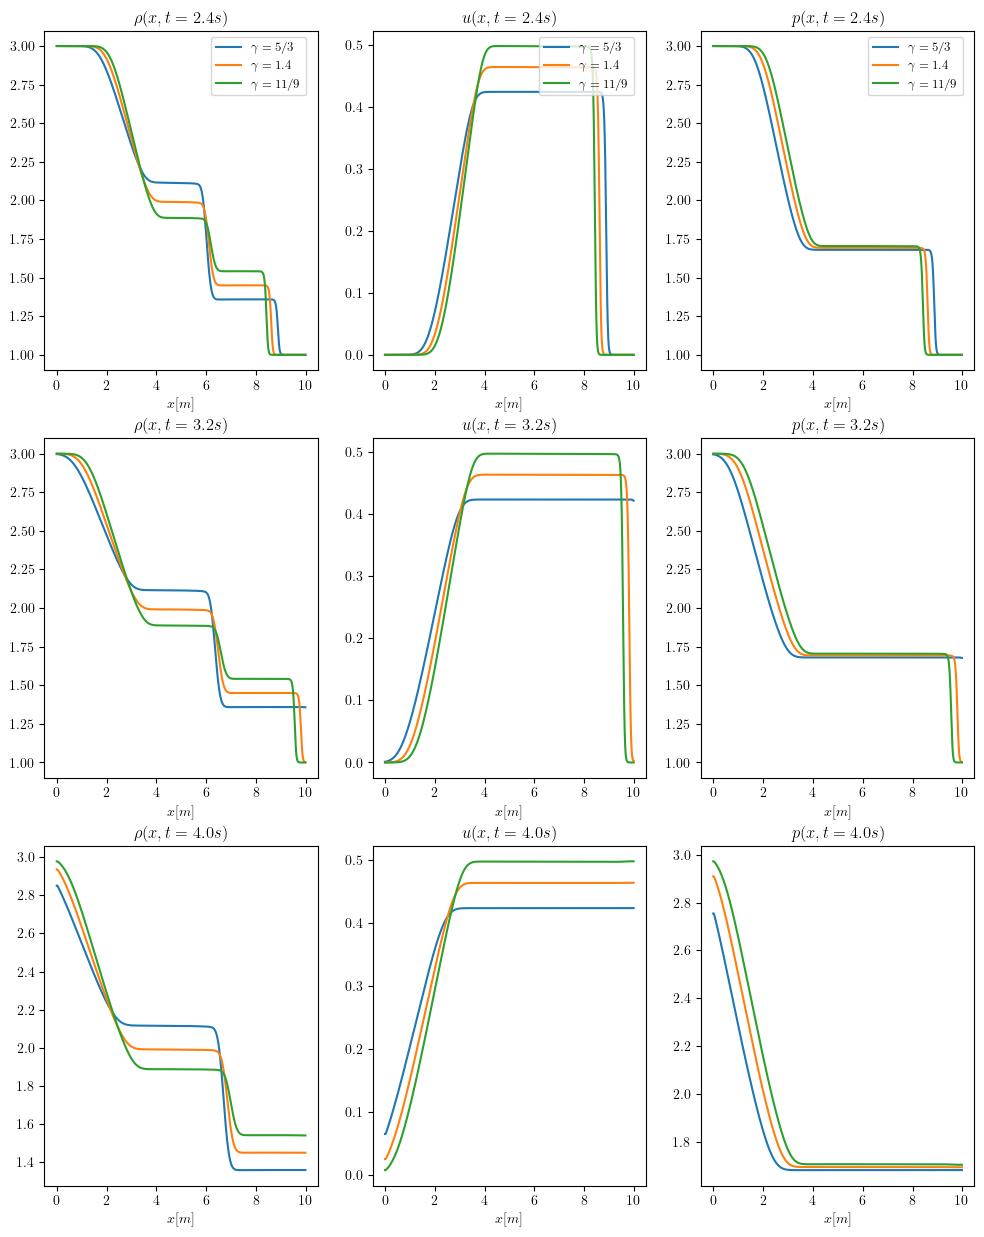

In [14]:
# prueba multiplots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, lista_plots = plt.subplots(3, 3, figsize=(12, 15))
instantes = [4,5,6]
variables_datos = {"rho": {"nombre": r"$\rho$"},
                   "u": {"nombre": r"$u$"},
                   "p": {"nombre": r"$p$"}}

# print(variables_datos["rho"]["nombre"])
for i in range(len(instantes)):
    instant = instantes[i]
    data_instant = data.query("Instante == @instant")
    tiempo = data_instant["t"].values[0]
    for j in range(3):
        variable = list(variables_datos.keys())[j]
        lista_plots[i][j]: plt.Axes
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.667"], label=r"$\gamma = 5/3$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.4"], label=r"$\gamma = 1.4$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.222"], label=r"$\gamma = 11/9$")
        titulo = variables_datos[variable]["nombre"].replace(r"$", "")
        titulo += f"(x,t = {tiempo}s)"
        titulo = r"$" + titulo + r"$"
        lista_plots[i][j].set_title(titulo)
        lista_plots[i][j].set_xlabel(r"$x[m]$")
        if i == 0:
            lista_plots[i][j].legend(fontsize = 9, loc='upper right', bbox_to_anchor=(0.98, 1.0))
plt.savefig(f'graficas_sod/2.pdf', bbox_inches='tight', pad_inches=0.05, format='pdf')


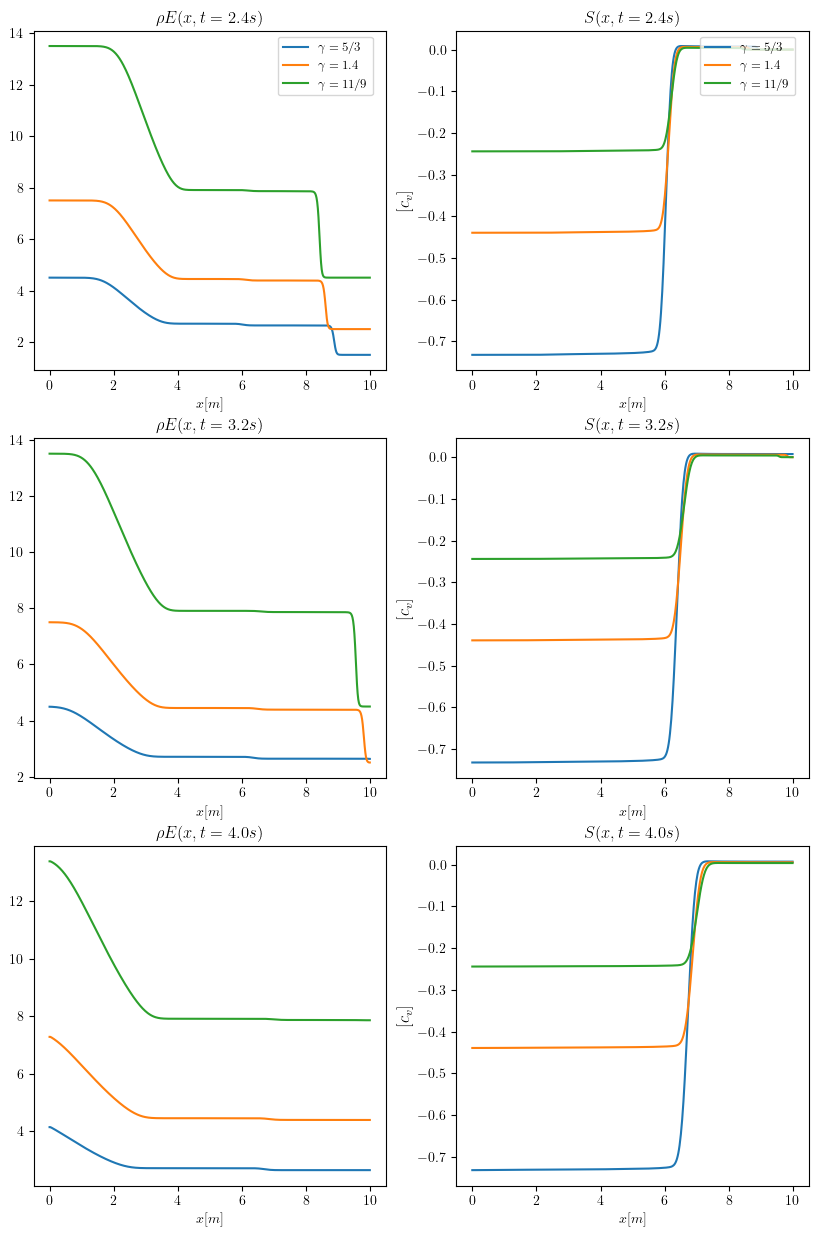

In [16]:
# Gráfica energía
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, lista_plots = plt.subplots(3, 2, figsize=(10, 15))
instantes = [4,5,6]
variables_datos = {"energia": {"nombre": r"$\rho E$"},
                   "entropia": {"nombre": r"$S$"}}

# print(variables_datos["rho"]["nombre"])
for i in range(len(instantes)):
    instant = instantes[i]
    data_instant = data.query("Instante == @instant")
    tiempo = data_instant["t"].values[0]
    for j in range(2):
        variable = list(variables_datos.keys())[j]
        lista_plots[i][j]: plt.Axes
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.667"], label=r"$\gamma = 5/3$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.4"], label=r"$\gamma = 1.4$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.222"], label=r"$\gamma = 11/9$")
        titulo = variables_datos[variable]["nombre"].replace(r"$", "")
        titulo += f"(x,t = {tiempo}s)"
        titulo = r"$" + titulo + r"$"
        lista_plots[i][j].set_title(titulo)
        lista_plots[i][j].set_xlabel(r"$x[m]$")
        if j == 1:
            lista_plots[i][j].set_ylabel(r"$[c_{v}]$", fontsize=12)
        if i == 0:
            lista_plots[i][j].legend(fontsize = 9, loc='upper right', bbox_to_anchor=(0.98, 1.0))
plt.savefig(f'energia/2.pdf', bbox_inches='tight', pad_inches=0.05, format='pdf')
